In [161]:
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.stats import calculate_p
from itertools import product, combinations

from deepjuice.model_zoo.options import get_model_options
model_info = get_model_options()

In [18]:
figure_path = '../reports/figures/ResultsSummary'

In [19]:
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']
perturbations = ['shuffled', 'no nouns', 'only verbs', 'no verbs', 'only nouns',]
annotated_features = ["spatial expanse", "interagent distance", "agents facing",
                      "object directed", "jointly acting", 
                      "communicating", "valence", "arousal"]

def feature_naming(features): 
    feature_rename_mapping = {}
    for orig in features:
        revised = orig.replace('rating-', '').replace('_', ' ')
        if 'expanse' in orig: 
            revised = 'spatial expanse'
        elif 'object' in orig: 
            revised = 'object directed'
        elif 'facingness' in orig:
            revised = 'agents facing'
        elif 'distance' in orig:
            revised = 'interagent distance'
        elif 'commu' in orig: 
            revised = 'communicating'
        elif 'joint' in orig:
            revised = 'jointly acting'
        feature_rename_mapping[orig] = revised
    return feature_rename_mapping

In [20]:
def add_perturbation(file_, df_):
    if 'none' in file_:
        df_['perturbation'] = 'original'
    elif 'mask_nonverbs' in file_:
        df_['perturbation'] = 'only verbs'
    elif 'mask_nonnouns' in file_:
        df_['perturbation'] = 'only nouns'
    elif 'mask_nouns' in file_:
        df_['perturbation'] = 'no nouns'
    elif 'mask_verbs' in file_:
        df_['perturbation'] = 'no verbs'
    else:
        df_['perturbation'] = 'shuffled'
    return df_


def add_model_class(file_, df_):
    if 'Vision' in file_:
        df_['model_class'] = 'image'
    elif 'Video' in file_:
        df_['model_class'] = 'video'
    else:
        df_['model_class'] = 'language'
    return df_


def add_model_type(file_, df_):
    if 'Language' in file_:
        df_['model_type'] = 'language'
    else:
        df_['model_type'] = 'vision'
    return df_


def mean_of_arrays(series):
    # Stack arrays vertically and compute mean along the first axis (rows)
    return np.nanmean(np.vstack(series),axis=0)

In [21]:
behavior_reliability = pd.read_csv(f'../data/interim/ReorganizeBehavior/metadata.csv')
behavior_reliability.replace(feature_naming(behavior_reliability.feature.unique()), inplace=True)
behavior_reliability['feature'] = pd.Categorical(behavior_reliability['feature'], categories=annotated_features, ordered=True)
behavior_reliability

,feature,reliability
0,spatial expanse,0.719483
1,object directed,0.928456
2,interagent distance,0.885451
3,agents facing,0.957481
4,jointly acting,0.768867
5,communicating,0.762171
6,valence,0.747964
7,arousal,0.683388


# Perturbations

## Behavior

In [8]:
df = []
for file in glob('../data/interim/ModelAveraging/*LanguageBehaviorEncoding*pkl.gz'):
    df.append(add_perturbation(file, pd.read_pickle(file)))
df = pd.concat(df)
df['feature'] = df['feature'].replace(feature_naming(df.feature.unique()))
df.set_index(['perturbation', 'feature'], inplace=True)

stats = []
for perturbation in perturbations:
    for feature in annotated_features:
        null_diff = df.loc['original', feature]['r_null_dist'] - df.loc[perturbation, feature]['r_null_dist'] 
        diff = df.loc['original', feature]['test_score'] - df.loc[perturbation, feature]['test_score']
        p = calculate_p(null_diff, diff, n_perm_=len(null_diff), H0_='greater')
        stats.append({'perturbation': perturbation, 'feature': feature, 'p': p})
stats = pd.DataFrame(stats)
stats['perturbation'] = pd.Categorical(stats['perturbation'], categories=['original']+perturbations, ordered=True)
stats['feature'] = pd.Categorical(stats['feature'], categories=annotated_features, ordered=True)
stats = stats.sort_values(by=['perturbation', 'feature']).reset_index(drop=True)

In [9]:
run_summary = False
if run_summary: 
    for perturb in ['none', 'shuffle', 'mask_nouns', 'mask_verbs', 'mask_nonnouns', 'mask_nonverbs']:
        os.system(f'ml anaconda; conda activate deepjuice; python ../scripts/model_summary.py --model_class LanguageBehaviorEncoding --model_subpath {perturb}')

df = []
for file in glob('../data/interim/ModelSummary/*LanguageBehaviorEncoding*csv.gz'):
    df.append(add_perturbation(file, pd.read_csv(file)))
df = pd.concat(df)
df = df.loc[df.set == 'test'].reset_index(drop=True)
df['feature'] = df['feature'].replace(feature_naming(df.feature.unique()))
df['perturbation'] = pd.Categorical(df['perturbation'], categories=['original']+perturbations, ordered=True)
df['feature'] = pd.Categorical(df['feature'], categories=annotated_features, ordered=True)

In [16]:
def plot_perturbation_summary(df_, category, stats=None, stats_ypos=None,
                              reliability_=None, out_file=None,
                              y_var='test_score', y_label='Score ($r$)', 
                              palette_name=None):
    if palette_name is None:
        palette = sns.color_palette("Paired", df_.perturbation.nunique())
    else:
        palette = sns.color_palette(palette_name, df_.perturbation.nunique())
    sns.set_context(context='notebook')
    fig, ax = plt.subplots(figsize=(8.5,3.65))
    sns.stripplot(x=category, y=y_var, hue='perturbation', data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  zorder=1, palette=palette)
    bars = sns.barplot(x=category, y=y_var, hue='perturbation', data=df_,
                       dodge=True, saturation=.4, errorbar=None,
                       legend=False, zorder=0, palette=palette)
    if stats is not None:
        containers = bars.containers[1:]
        orig_container = bars.containers[0]
        counter = -1
        for i_container, container in enumerate(containers):
            for i_bar, (orig_bar, bar) in enumerate(zip(orig_container, container.patches)):
                counter += 1
                if stats.iloc[counter]['p'] < 0.05:
                    ypos = stats_ypos[stats.iloc[counter]['perturbation']]
                    xmin = orig_bar.get_x() #+ (orig_bar.get_width() / 2)
                    xmax = bar.get_x() + (bar.get_width() / 2)
                    color = bar.get_facecolor()
                    plt.hlines(y=ypos, xmin=xmin, xmax=xmax,
                               linewidth=2, color=color)
    
    if reliability_ is not None:
        sns.pointplot(x=category, y='reliability', data=reliability_,
                      ax=ax, linestyle="none", errorbar=None, 
                      marker="_", markersize=30, markeredgewidth=7,
                      color='gray', alpha=.25, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    # ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              ncol=1, fancybox=True)
    
    # Manually insert line breaks in tick labels
    tick_labels = ax.get_xticklabels()
    for label in tick_labels:
        # Insert a line break after the first word
        new_label = label.get_text().replace(' ', '\n', 1)
        if label.get_text() == 'communicating':
            new_label = 'communi- \n cating'
        label.set_text(new_label)
    ax.set_xticklabels(tick_labels)
    
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)

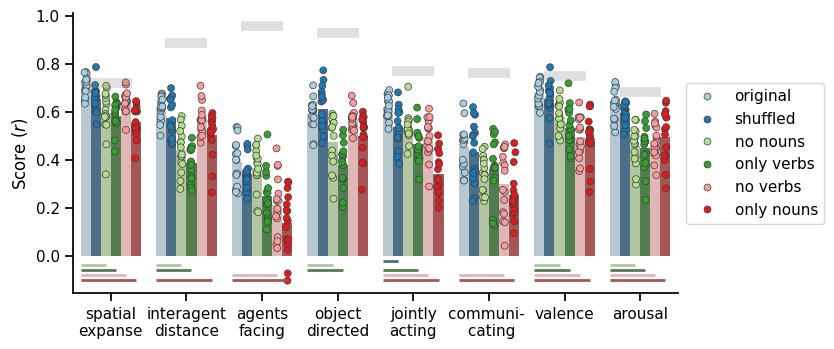

In [22]:
y_pos = {perturbation: (i_perturb+1)*-0.02 
         for i_perturb, perturbation in enumerate(perturbations)}
plot_perturbation_summary(df, 'feature', reliability_=behavior_reliability,
                          stats=stats,
                          y_var='score', stats_ypos=y_pos,
                          out_file='../reports/figures/ResultsSummary/behavior_pertubations.pdf')

## Neural

In [87]:
def plot_neural_perturbation_summary(df_, category, roi_grouping, 
                                      reliability_=None, out_file=None, stats=None,
                                      y_var='test_score', y_label='Score ($r$)', 
                                      palette_name=None, stats_ypos=None):
    if palette_name is None:
        palette = sns.color_palette("Paired", df_.perturbation.nunique())
    else:
        palette = sns.color_palette(palette_name, df_.perturbation.nunique())
    _, axes = plt.subplots(1, 2, figsize=(8, 3.5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    regions = ['Lateral ROIs', 'Ventral ROIs']
    
    for i_ax, (ax, (stream_name, cur_scores)) in enumerate(zip(axes, df_.groupby('roi_stream'))):    
        legend = True if i_ax == 1 else False
        cur_scores.reset_index(drop=True, inplace=True)
        cur_scores[category] = pd.Categorical(cur_scores[category], ordered=True,
                                              categories=roi_grouping[i_ax])
        sns.stripplot(x=category, y=y_var, hue='perturbation', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      zorder=1, palette=palette, legend=legend)
        bars = sns.barplot(x=category, y=y_var, hue='perturbation', data=cur_scores,
                            ax=ax, dodge=True, errorbar=None, saturation=.25,
                            legend=False, zorder=0, palette=palette)
        sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=45, markeredgewidth=5,
              alpha=.5, zorder=1, ax=ax)

        if stats is not None: 
            # Adding significance lines    
            original_container = bars.containers[0]
            containers = bars.containers[1:]

            counter = -1
            for i_container, container in enumerate(containers):
                for i_bar, bar in enumerate(container.patches):
                    counter += 1
                    if stats.iloc[counter]['p'] < 0.05: 
                        x_min = original_container.patches[i_bar].get_x() + bar.get_width() / 2
                        x_max = bar.get_x() + bar.get_width() / 2
                        yval = stats_ypos[stats.iloc[counter]['perturbation']]
                        plt.hlines(y=yval, xmin=x_min, xmax=x_max,
                                   color=bar.get_facecolor(), linewidth=2)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ticks = ax.get_xticks()
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticks(ticks)
        ax.set_xlabel(stream_name)
        ax.set_ylabel(y_label)
        if legend: 
            ax.legend(loc='center right', bbox_to_anchor=(2, 0.5),
                      ncol=1, fancybox=True)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)

In [25]:
run_summary = False
if run_summary: 
    for perturb in ['none', 'shuffle', 'mask_nouns', 'mask_verbs', 'mask_nonnouns', 'mask_nonverbs']:
        os.system(f'ml anaconda; conda activate deepjuice; python ../scripts/model_summary.py --model_class LanguageNeuralEncoding --model_subpath {perturb}')

df = []
for file in glob('../data/interim/ModelSummary/*LanguageNeuralEncoding*csv.gz'):
    df.append(add_perturbation(file, pd.read_csv(file)))
df = pd.concat(df)
df = df.loc[df.set == 'test'].reset_index(drop=True)
df['perturbation'] = pd.Categorical(df['perturbation'], categories=['original']+perturbations, ordered=True)
df['roi_name'] = pd.Categorical(df['roi_name'], categories=rois, ordered=True)

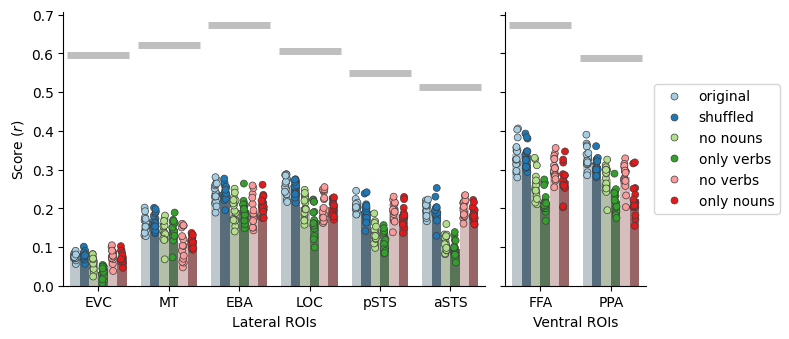

In [88]:
df['roi_stream'] = 'Lateral ROIs' 
df.loc[df.roi_name.isin(['FFA', 'PPA']), 'roi_stream'] = 'Ventral ROIs'
roi_grouping = [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']]
plot_neural_perturbation_summary(df, 'roi_name', roi_grouping,
                          y_var='score', 
                          out_file=f'{figure_path}/neural_pertubations.pdf')

# Image vs Video vs Language

## Behavior

In [289]:
def plot_combined_behavior_summary(df_, reliability_, hue='model_class', out_file=None):
    anchor = (.8, 1.2)
    if hue == 'model_class':
        sns.set_palette(['tab:cyan', 'tab:purple'])
    elif hue == 'model_type':
        sns.set_palette(['tab:cyan', 'tab:purple'])
        anchor = (.7, 1.2)
    elif hue == 'architecture_type':
        sns.set_palette(['tab:orange', 'tab:green'])
    elif hue == 'task_cluster':
        sns.set_palette(['tab:red', 'gold'])
    elif hue == 'modality':
        sns.set_palette(['tab:pink', 'skyblue'])
        
    if df_[hue].nunique() == 3:
        dodge = 0.55
        markersize = 14
    else:
        dodge = 0.4
        markersize = 18

    sns.set_context(context='notebook')
    _, ax = plt.subplots(figsize=(7,3.65))
    sns.stripplot(x='feature', y='score', hue=hue, data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    sns.pointplot(x='feature', y='score', hue=hue, data=df_,
                  dodge=dodge, linestyle="none", errorbar=None,
                  marker="_", markersize=markersize, markeredgewidth=3, zorder=1)
    sns.pointplot(x='feature', y='reliability', data=reliability_,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=30, markeredgewidth=5,
                  color='gray', alpha=.5, zorder=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xlabel('')
    ax.set_ylabel('Score ($r$)')
    ax.legend(loc='upper right', bbox_to_anchor=anchor,
              ncol=df_[hue].nunique(), fancybox=True)
    
    # Manually insert line breaks in tick labels
    tick_labels = ax.get_xticklabels()
    for label in tick_labels:
        # Insert a line break after the first word
        new_label = label.get_text().replace(' ', '\n', 1)
        if label.get_text() == 'communicating':
            new_label = 'communi- \n cating'
        label.set_text(new_label)
    ax.set_xticklabels(tick_labels)
    
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)

In [290]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageBehaviorEncoding_none.csv.gz']
files += [f'{top}/VisionBehaviorEncoding_grouped_average.csv.gz']
files += [f'{top}/VideoBehaviorEncoding_None.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df.replace(feature_naming(df.feature.unique()), inplace=True)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['model_type'] = pd.Categorical(df['model_type'], ordered=True, 
                                   categories=['vision', 'language'])
df['feature'] = pd.Categorical(df['feature'], ordered=True, 
                                   categories=annotated_features)
df = df.loc[df.set == 'test'].reset_index(drop=True)

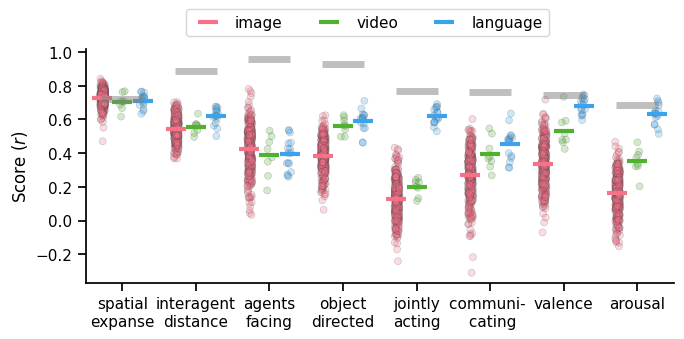

In [291]:
plot_combined_behavior_summary(df, behavior_reliability,
                               out_file=f'{figure_path}/behavior_summary.pdf')

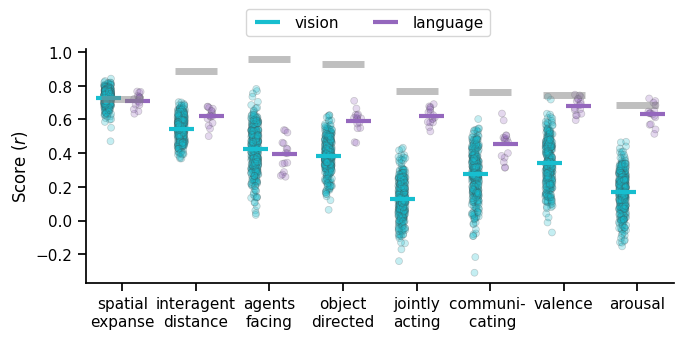

In [292]:
plot_combined_behavior_summary(df, behavior_reliability, hue='model_type',
                               out_file=f'{figure_path}/behavior_vision-language.pdf')

In [293]:
image_df = df.loc[df.model_class == 'image'].reset_index(drop=True).merge(model_info, on='model_uid')

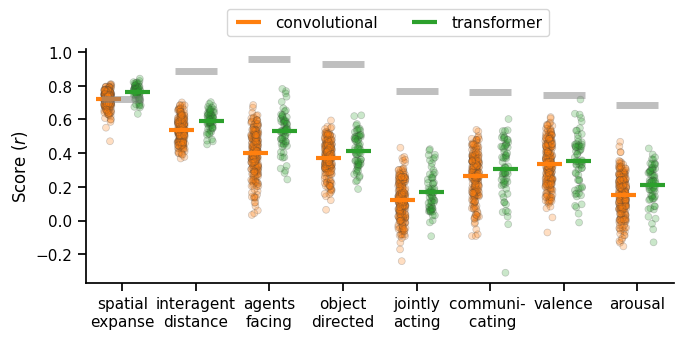

In [294]:
conv_meta_max = image_df[image_df['architecture_type'].isin(['Convolutional', 'Transformer'])]
mapping = {i: i.lower() for i in ['Convolutional', 'Transformer']}
conv_meta_max.replace(mapping, inplace=True)
conv_meta_max['architecture_type'] = pd.Categorical(conv_meta_max['architecture_type'], 
                                                    categories=mapping.values(), ordered=True)
plot_combined_behavior_summary(conv_meta_max, behavior_reliability,
                               hue='architecture_type',
                               out_file=f'{figure_path}/behavior_conv-transformer.pdf')

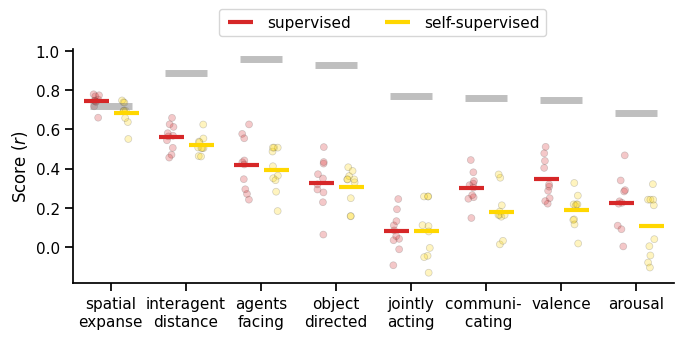

In [295]:
categories = ['Supervised', 'Self-Supervised']

resnet_info = model_info[(model_info['model_source'].isin(['torchvision', 'vissl', 'dino', 'timm'])) & (model_info['architecture'].str.contains('resnet50'))]
resnet_df = image_df[image_df['model_uid'].isin(resnet_info.model_uid)]
sup_meta_max = resnet_df[resnet_df['task_cluster'].isin(categories)]
mapping = {i: i.lower() for i in categories}
sup_meta_max.replace(mapping, inplace=True)
sup_meta_max['task_cluster'] = pd.Categorical(sup_meta_max['task_cluster'], 
                                                    categories=mapping.values(), ordered=True)

plot_combined_behavior_summary(sup_meta_max, behavior_reliability,
                               hue='task_cluster',
                               out_file=f'{figure_path}/behavior_sup-selfsup.pdf')

## Neural

### Functional ROIs

In [177]:
top = '../data/interim/ModelAveraging'
files = [f'{top}/LanguageNeuralEncoding_none.pkl.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average.pkl.gz']
files += [f'{top}/VideoNeuralEncoding_None.pkl.gz']
df = []
for file in tqdm(files):
    cdf = pd.read_pickle(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)

neural_metadata = pd.read_csv('../data/interim/ReorganziefMRI/metadata.csv')
df = df.merge(neural_metadata, on='voxel_id')
df_filtered = df.loc[df.roi_name != 'none'].reset_index()

stats_df = df_filtered.groupby(['roi_name',
                                'model_class']).agg({'test_score': 'mean', 
                                                     'layer_relative_depth': 'mean',
                                                     'reliability': 'mean',
                                                     'r_null_dist': mean_of_arrays,
                                                    }).reset_index()

stats = []
model_classes = stats_df.model_class.unique()
for roi, roi_df in stats_df.groupby('roi_name'):
    roi_df.set_index('model_class', inplace=True)
    for model1, model2 in combinations(model_classes, 2):
        null_diff = roi_df.loc[model1, 'r_null_dist'] - roi_df.loc[model2, 'r_null_dist']
        r_diff = roi_df.loc[model1, 'test_score'] - roi_df.loc[model2, 'test_score']
        p = calculate_p(null_diff, r_diff,
                        n_perm_=len(null_diff), H0_='two_tailed')
        stats.append({'roi_name': roi,
                      'model1': model1, 'model2': model2, 'p': p})
stats = pd.DataFrame(stats)

100%|██████████| 3/3 [00:16<00:00,  5.64s/it]


In [196]:
df_wholebrain = df.drop(columns=['r_null_dist'])
df_vision = df_wholebrain.loc[df_wholebrain.model_type == 'vision']
n_models = np.array(df_vision.n_models.unique()).sum()
print(n_models)
vision_avg = []
for voxel_id, voxel_df in tqdm(df_vision.groupby('voxel_id')):
    voxel_df.set_index('model_class', inplace=True)
    voxel_result = {'voxel_id': voxel_id, 'model_type': 'vision'}
    
    for col in ['test_score', 'layer_relative_depth']:
        val = 0
        for model_class in ['image', 'video']: 
            val += voxel_df.loc[model_class, col] * (voxel_df.loc[model_class,
                                                                  'n_models']/n_models)
        voxel_result[col] = val
    vision_avg.append(voxel_result)
vision_avg = pd.DataFrame(vision_avg)
vision_avg.set_index('voxel_id', inplace=True)

350


100%|██████████| 177753/177753 [00:48<00:00, 3664.52it/s]


In [204]:
cols = ['voxel_id', 'model_type', 'test_score', 'layer_relative_depth']
lang_avg = df_wholebrain.loc[df_wholebrain.model_type == 'vision', cols].set_index('voxel_id')
whole_brain_diff = vision_avg['test_score'] - lang_avg['test_score']
whole_brain_diff = pd.DataFrame(whole_brain_diff).merge(neural_metadata, on='voxel_id')


,voxel_id,test_score,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index
0,0,0.001004,none,none,1,0.322961,2,33,31
1,0,-0.042920,none,none,1,0.322961,2,33,31
2,1,-0.000312,none,none,1,0.340669,2,33,32
3,1,0.013346,none,none,1,0.340669,2,33,32
4,2,-0.000195,none,none,1,0.313496,2,34,35
...,...,...,...,...,...,...,...,...,...
355501,177750,0.001425,none,none,4,0.277799,71,32,42
355502,177751,0.000200,none,none,4,0.271619,71,33,30
355503,177751,-0.008570,none,none,4,0.271619,71,33,30
355504,177752,0.001290,none,none,4,0.303402,71,34,42


In [209]:
def plot_combined_neural_fROIs(df_, hue='model_class', out_file=None):
    anchor = (1, 1.2)
    if hue == 'model_class':
        sns.set_palette(['tab:cyan', 'tab:purple'])
        anchor = (1, 1.2)
    elif hue == 'model_type':
        sns.set_palette(['tab:cyan', 'tab:purple'])
    elif hue == 'architecture_type':
        sns.set_palette(['tab:orange', 'tab:green'])
    elif hue == 'task_cluster':
        sns.set_palette(['tab:red', 'gold'])
    elif hue == 'modality':
        sns.set_palette(['tab:pink', 'skyblue'])
    regions = ['Lateral ROIs', 'Ventral ROIs']
    
    if df_[hue].nunique() == 3:
        dodge = 0.55
        markersize = 14
    else:
        dodge = 0.4
        markersize = 18

    _, axes = plt.subplots(1, 2, figsize=(6.5, 3.5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                              [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'],
                                               ['FFA', 'PPA']])):
        legend = True if i_ax == 0 else False

        cur_scores = df_[df_.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='roi_name', y='score', hue=hue, data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        sns.pointplot(x='roi_name', y='score', hue=hue,
                      data=cur_scores, legend=legend,
                      ax=ax, dodge=dodge, linestyle="none", errorbar=None,
                      marker="_", markersize=markersize,
                      markeredgewidth=3, zorder=1)
        sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=45, markeredgewidth=5,
              alpha=.5, zorder=1, ax=ax)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(regions[i_ax])
        if i_ax == 0: 
            ax.set_ylabel('Score ($r$)')
            ax.legend(loc='upper right', bbox_to_anchor=anchor,
                      ncol=df_[hue].nunique(), fancybox=True)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)

In [210]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageNeuralEncoding_none_roi_name.csv.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average_roi_name.csv.gz']
files += [f'{top}/VideoNeuralEncoding_None_roi_name.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['model_type'] = pd.Categorical(df['model_type'], ordered=True, 
                                   categories=['vision', 'language'])
df = df.loc[df.set == 'test'].reset_index(drop=True)

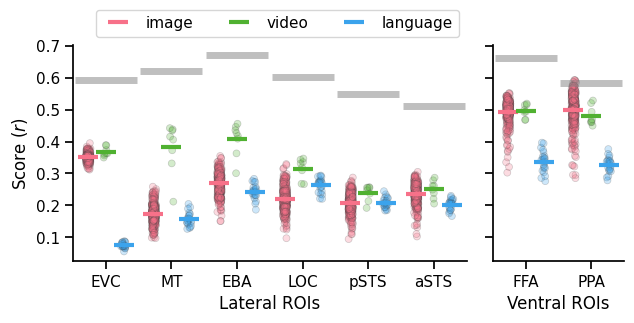

In [211]:
plot_combined_neural_fROIs(df, hue='model_class',
                           out_file=f'{figure_path}/neural_summary.pdf')

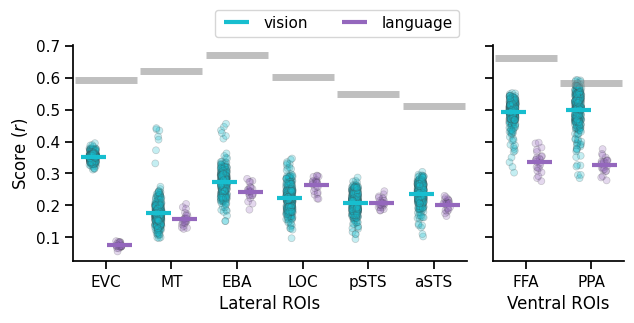

In [212]:
plot_combined_neural(df, hue='model_type',
                     out_file=f'{figure_path}/neural_vision-language.pdf')

In [123]:
image_df = df.loc[df.model_class == 'image'].reset_index(drop=True).merge(model_info, on='model_uid')

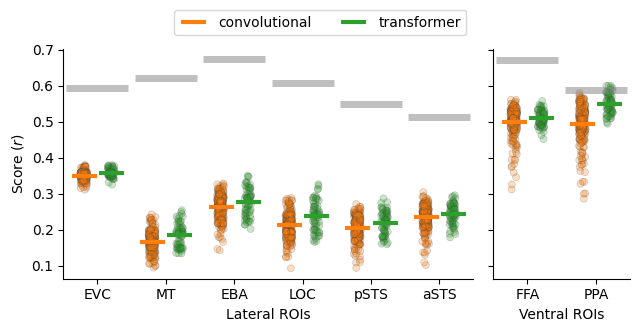

In [124]:
categories = ['Convolutional', 'Transformer']
hue = 'architecture_type' 

conv_meta_max = image_df[image_df[hue].isin(categories)]
mapping = {i: i.lower() for i in categories}
conv_meta_max.replace(mapping, inplace=True)
conv_meta_max[hue] = pd.Categorical(conv_meta_max[hue],
                                    categories=mapping.values(), ordered=True)
plot_combined_neural(conv_meta_max, hue=hue,
                     out_file=f'{figure_path}/neural_conv-transformer.pdf')

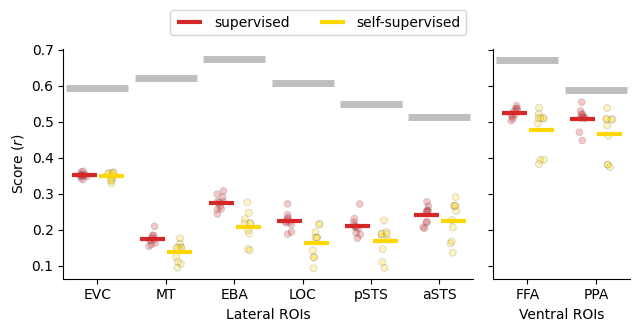

In [125]:
categories = ['Supervised', 'Self-Supervised']
hue = 'task_cluster' 

resnet_info = model_info[(model_info['model_source'].isin(['torchvision', 'vissl', 'dino', 'timm'])) & (model_info['architecture'].str.contains('resnet50'))]
resnet_df = image_df[image_df['model_uid'].isin(resnet_info.model_uid)]
sup_meta_max = resnet_df[resnet_df[hue].isin(categories)]
mapping = {i: i.lower() for i in categories}
sup_meta_max.replace(mapping, inplace=True)
sup_meta_max[hue] = pd.Categorical(sup_meta_max[hue],
                                   categories=mapping.values(), ordered=True)

plot_combined_neural(sup_meta_max, hue=hue,
                     out_file=f'{figure_path}/neural_sup-selfsup.pdf')

### Anatomical ROIs

In [264]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageNeuralEncoding_none_stream_name.csv.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average_stream_name.csv.gz']
files += [f'{top}/VideoNeuralEncoding_None_stream_name.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['model_type'] = pd.Categorical(df['model_type'], ordered=True, 
                                   categories=['vision', 'language'])
df = df.loc[df.set == 'test'].reset_index(drop=True)

In [265]:
def plot_combined_neural_aROIs(df_, hue='model_class', out_file=None):
    anchor = (1.2, 1.25)
    if hue == 'model_class':
        sns.set_palette(['tab:cyan', 'tab:purple'])
        anchor = (1.55, 1.25)
    elif hue == 'model_type':
        sns.set_palette(['tab:cyan', 'tab:purple'])
    elif hue == 'architecture_type':
        sns.set_palette(['tab:orange', 'tab:green'])
    elif hue == 'task_cluster':
        sns.set_palette(['tab:red', 'gold'])
    elif hue == 'modality':
        sns.set_palette(['tab:pink', 'skyblue'])
    regions = ['', 'Lateral stream', 'Ventral stream',]
    
    if df_[hue].nunique() == 3:
        dodge = 0.55
        markersize = 14
    else:
        dodge = 0.4
        markersize = 18
    
    _, axes = plt.subplots(1, 3, figsize=(5.5, 3),
                           gridspec_kw={'width_ratios': [1, 2, 2]},
                          sharey=True)
    for i_ax, (ax, (cur_rois, ticks)) in enumerate(zip(axes, zip([['evc'],
                                                         ['mid_lateral', 'high_lateral'],
                                                         ['mid_ventral', 'high_ventral']],
                                                        [['EVC'], ['mid', 'high'], ['mid', 'high']]))):
        legend = True if i_ax == 1 else False
        cur_scores = df_[df_.stream_name.isin(cur_rois)]
        cur_scores['stream_name'] = pd.Categorical(cur_scores['stream_name'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='stream_name', y='score', hue=hue, data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        sns.pointplot(x='stream_name', y='score', hue=hue,
                      data=cur_scores, legend=legend,
                      ax=ax, dodge=dodge, linestyle="none", errorbar=None,
                      marker="_", markersize=markersize,
                      markeredgewidth=3, zorder=1)
        sns.pointplot(x='stream_name', y='reliability', data=cur_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=45, markeredgewidth=5,
              alpha=.5, zorder=1, ax=ax)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(regions[i_ax])
        ax.set_ylabel('Score ($r$)')
        ax.set_xticks(cur_rois) 
        ax.set_xticklabels(ticks)
    plt.tight_layout()
    axes[1].legend(loc='upper right', bbox_to_anchor=anchor,
          ncol=df_[hue].nunique(), fancybox=True)
    if out_file is not None:
        plt.savefig(out_file, bbox_inches='tight')

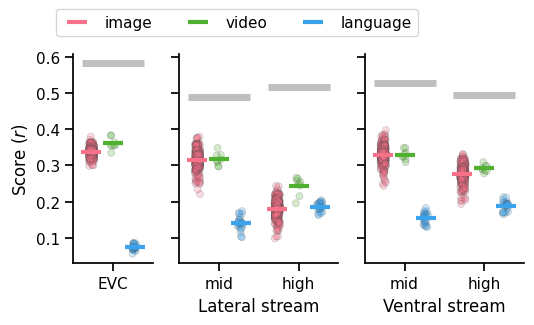

In [266]:
plot_combined_neural_aROIs(df, hue='model_class',
                           out_file=f'{figure_path}/stream_summary.pdf')

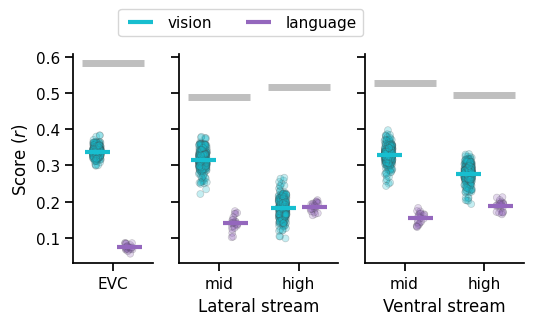

In [267]:
plot_combined_neural_aROIs(df, hue='model_type',
                           out_file=f'{figure_path}/stream_vison-language.pdf')